In [1]:
from src.dataLoader import DataLoader
from src.statisticalTests import dickyFuller, modelEvaluation
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import seaborn as sns
from fitter import Fitter

# Import data

In [2]:
pathToData = "data/TSLA.csv"
dl = DataLoader(pathToData)
dl.processData()

## Split data

In [3]:
# Set what data to be analysed
inputData = dl.returnsClosing
datesInputData = dl.returnClosingDates

In [4]:
# Split data into train and test
predictionRange = 10
dl.setIndicesTrainTestSplit(len(inputData), predictionRange)
xTrain, xTest = dl.trainTestSplit(inputData)

In [5]:
# Only add a few dates to the x-axis
indicesXAxis = np.linspace(0,len(datesInputData)-1, 10, dtype=int)

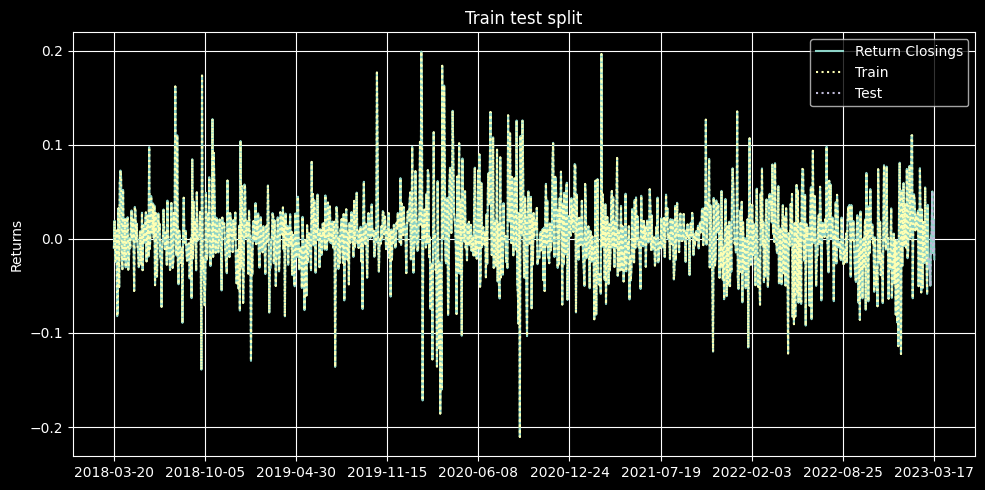

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(datesInputData, inputData, label="Return Closings")
plt.plot(datesInputData[:dl.numberTrainData], xTrain,":", label="Train")
plt.plot(datesInputData[dl.numberTrainData:], xTest,":", label="Test")
plt.title('Train test split')
plt.xticks(datesInputData[indicesXAxis])
plt.ylabel('Returns')
plt.legend()
plt.grid()
plt.tight_layout()


### Is the time serie stationary?
- Constant mean: there exist $ \mu \in$ $\mathbb{R}$ such that $\mu_{X}$(t) = $\mu$ for all t $\in$ Z
- Constant autocovariance: $\gamma_{X}$(r,s) =  $\gamma_{X}$(r+h,s+h) for all s,r,h $ \in $ Z

Statistical test: augmented Dicky-Fuller

-> Transform the data into a stationary form

In [7]:

classDickyFuller = dickyFuller()
df = classDickyFuller.getDickyFullerScores(xTrain)
print(df)


  regression       adf        pvalue  usedlag  nobs  critical values: 1%   
0          c -7.189194  2.529682e-10       23  1224            -3.435704  \
1         ct -7.211962  4.660451e-09       23  1224            -3.966185   
2        ctt -7.491772  5.621841e-09       23  1224            -4.380622   

   critical values: 5%  critical values: 10%    icbest  
0            -2.863904             -2.568029  1.993066  
1            -3.414083             -3.129165  1.983524  
2            -3.837223             -3.556253  1.835022  


In [8]:

returnClosingDiff, _ = dl.removeNans(dl.computeDifference(xTrain))
df = classDickyFuller.getDickyFullerScores(returnClosingDiff)
print(df)


  regression        adf        pvalue  usedlag  nobs  critical values: 1%   
0          c -12.246836  9.740160e-23       23  1223            -3.435708  \
1         ct -12.241457  1.597942e-19       23  1223            -3.966191   
2        ctt -12.237211  6.649288e-20       23  1223            -4.380629   

   critical values: 5%  critical values: 10%    icbest  
0            -2.863906             -2.568030  2.483409  
1            -3.414086             -3.129167  2.482170  
2            -3.837227             -3.556256  2.482785  


# Correlation plots

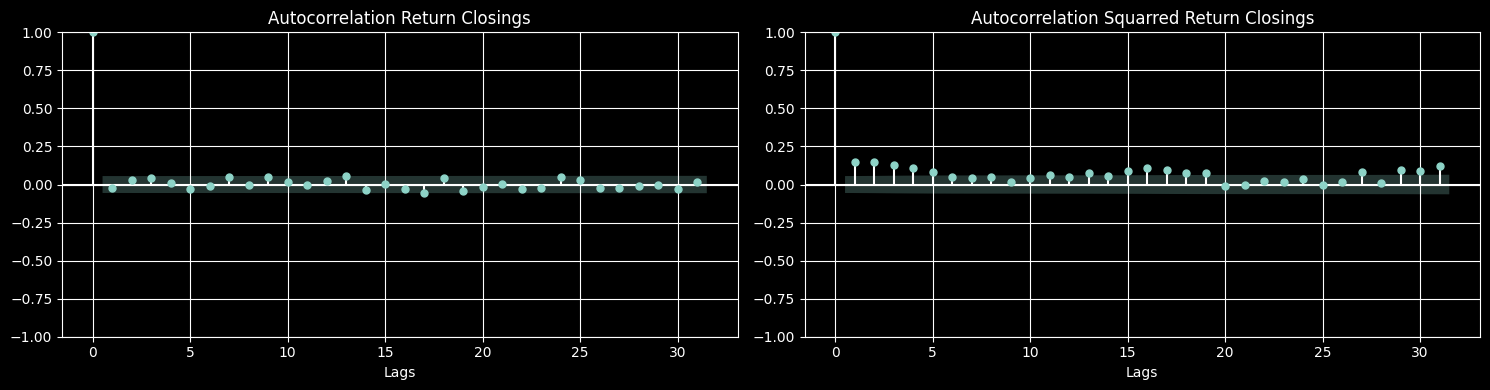

In [9]:
fig, axs = plt.subplots(1,2, figsize=(15,4))
plot_acf(xTrain, ax=axs[0])
axs[0].grid()
axs[0].set_xlabel("Lags")
axs[0].set_title("Autocorrelation Return Closings")
plot_acf(xTrain ** 2., ax=axs[1])
axs[1].grid()
axs[1].set_xlabel("Lags")
axs[1].set_title("Autocorrelation Squarred Return Closings")
fig.tight_layout()


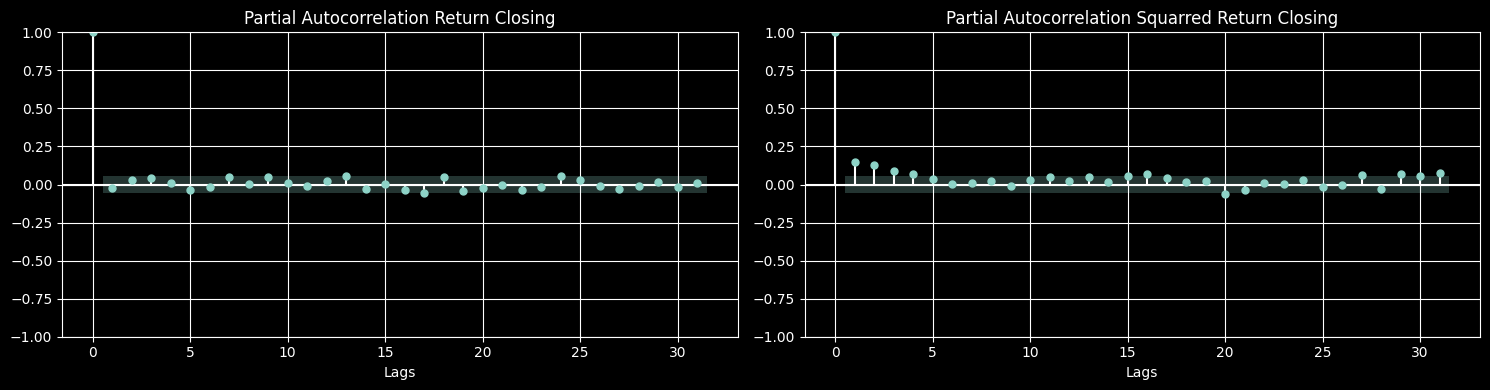

In [10]:
fig, axs = plt.subplots(1,2, figsize=(15,4))
plot_pacf(xTrain, ax=axs[0])
axs[0].grid()
axs[0].set_xlabel("Lags")
axs[0].set_title("Partial Autocorrelation Return Closing")
plot_pacf(xTrain ** 2., ax=axs[1])
axs[1].grid()
axs[1].set_xlabel("Lags")
axs[1].set_title("Partial Autocorrelation Squarred Return Closing")
fig.tight_layout()


# Get best AutoRegressive model
Depending relationship between an observation and p number of lagged observations.

In [11]:
arma = modelEvaluation(dl.numberTrainData)
aic, order, myModel = arma.getBestModel(xTrain, pMax=5, dMax=1, qMax=5)
myModel.summary()


AIC: -4363.38668 | order: (2, 0, 2)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1248
Model:                 ARIMA(2, 0, 2)   Log Likelihood                2186.693
Date:                Tue, 16 May 2023   AIC                          -4363.387
Time:                        16:18:21   BIC                          -4337.740
Sample:                             0   HQIC                         -4353.745
                               - 1248                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6565      0.070      9.394      0.000       0.519       0.793
ar.L2         -0.8425      0.066    -12.856      0.000      -0.971      -0.714
ma.L1         -0.6810      0.058    -11.749      0.000      -0.795      -0.567
ma.L2          0.8939      0.055     16.118      0.000       0.785       1.003
sigma2         0.0018   4.54e-05     38.742      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               503.91
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.22   Skew:                             0.19
Prob(H) (two-sided):                  0.04   Kurtosis:                         6.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Distrubtions
Fit suitable distribution for the data, to be used for modelling

In [12]:
distributionList = ['gamma','t', 'lognorm', "beta", "burr", "norm"]

In [13]:
def plotDistributions(inputData):
    """ plot distribution of returns and log returns then fit a distribution in the plot both t-dist and Gaussian
    """

    fig = sm.qqplot(inputData, line='45')
    
    sns.set_style('white')
    sns.set_context("paper", font_scale = 2)
    print(sns.__version__)
    sns.displot(inputData, bins = 100, aspect = 1.5)
    plt.grid()

    f = Fitter(inputData, distributions=distributionList)
    f.fit()
    f.summary()
    return
 

0.12.2


Fitting 6 distributions: 100%|██████████| 6/6 [00:01<00:00,  4.00it/s]


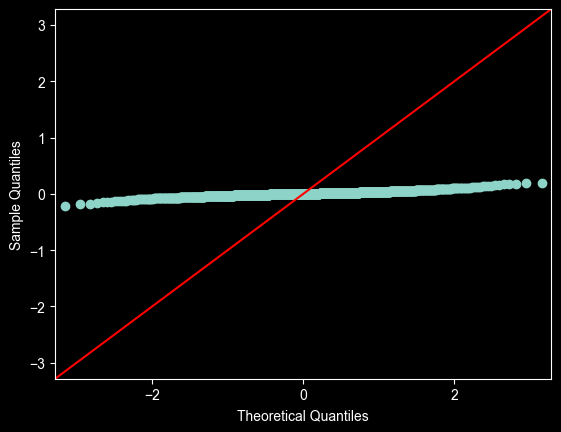

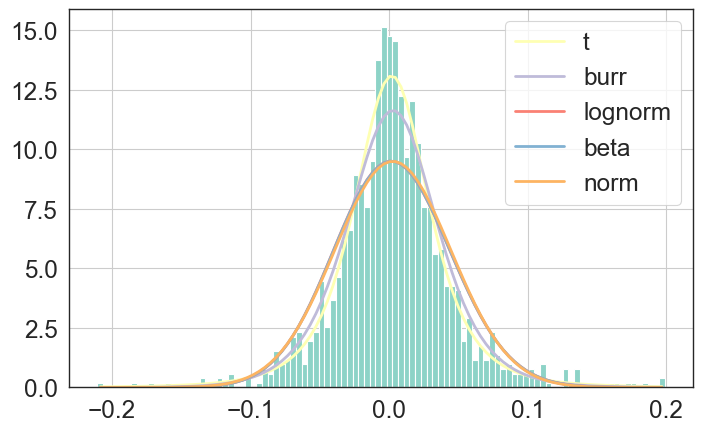

In [14]:
plotDistributions(dl.returnsClosing)